In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import time

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, 'util')
import vcpi_util

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(device)

2.3.0+cpu
cpu


### Settings

In [15]:
PATH_TEST_SET = "data/test_images"
IMG_SIZE = 32
BATCH_SIZE = 64

model_paths = [
    'models/model6fr.pt',
    'models/model11fr.pt',
    'models/model12fr.pt'
]

### Aux

In [10]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    with torch.no_grad():
        for i, (images, targets) in enumerate(data_loader):

            # forward pass, compute the output of the model for the current batch
            outputs = model(images.to(device))

            # "max" returns a namedtuple (values, indices) where values is the maximum 
            # value of each row of the input tensor in the given dimension dim; 
            # indices is the index location of each maximum value found (argmax).
            # the argmax effectively provides the predicted class number        
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == targets).sum()

    return (correct / len(data_loader.dataset)).item()


class Conv(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, 3)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(1200, num_classes)
        

    def forward(self, x):    
        
        # input = (bs, 3, 32, 32)
        x = self.conv1(x) # -> (bs, 16, 30, 30)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x) # -> (bs, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool1(x) # -> (bs, 32, 14, 14)
        
        x = self.conv3(x) # -> (bs, 48, 12, 12)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x) # -> (bs, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool2(x) # -> (bs, 48, 5, 5)
        
        x = torch.flatten(x,1) # -> (bs, 48 * 5 * 5 = 1200)
        x = self.fc1(x)        # -> (bs, num_classes)

        return(x)



### Load Test Dataset

In [11]:
from torchvision.transforms import v2

test_transform = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
])

test_set = torchvision.datasets.ImageFolder(root=PATH_TEST_SET, transform = test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE)

### Load Models

In [18]:


models = []
accs = []

for mpaths in model_paths:
    model = Conv(len(test_set.classes))
    model.load_state_dict(torch.load(mpaths)['model'])
    models.append(model)
    model.to(device)
    accs.append(evaluate(model,test_loader))
    

### Models Accuracy 

0.9879651467005411 0.9917656183242798 0.9843230247497559


(0.97, 1.0)

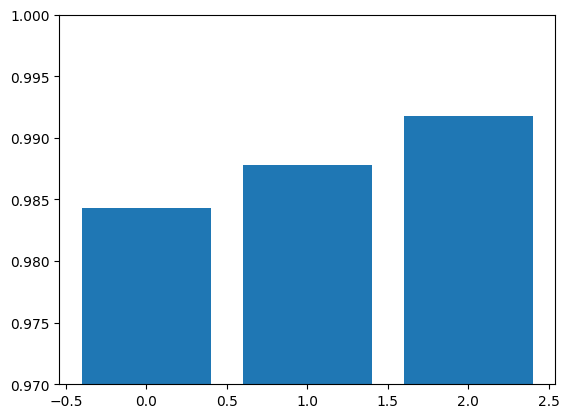

In [24]:
index = [i for i in range(len(accs))]

plt.bar(index, accs)
print(np.mean(accs), np.max(accs), np.min(accs))
plt.ylim(0.97,1.0)

### Ensemble

In [26]:
def get_labels_logits_and_preds(models):

    with torch.no_grad():
        logits = [[] for _ in models]
        labels = []

        for images, labs in test_loader:

            images = images.to(device)
            labels.extend(labs)
            
            for i in range(len(models)):
                logits[i].extend(models[i](images).cpu())


    return labels, logits

labels, logits = get_labels_logits_and_preds(models)

In [28]:
preds = [[] for _ in range(len(labels)) ]

for index in range(len(labels)):
    preds[index] = [np.argmax(logits[m][index].cpu().numpy()) \
                    for m in range(len(models))]

In [30]:
def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(len(logits[0])):

        log = logits[0][i]
        for m in range(1, len(models)):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    
class_logits = get_class_from_sum_of_logits(logits)    

In [31]:
print(class_logits[0])

tensor(0)


In [32]:
import collections 

def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0

    for k in range(len(labels)):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1

        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong]
    
    
res = get_stats(labels, preds, class_logits)
print('total: ', res[0])
print('All correct: ', res[1])
print('All incorrect: ', res[2])
print('Majority correct: ', res[3])
print('Tie Vote: ', res[4])
print('Majority Wrong: ', res[5])
print('Percentage right: ', (res[1]+res[3])/res[0])

total:  12630
All correct:  12307
All incorrect:  11
Majority correct:  214
Tie Vote:  30
Majority Wrong:  68
Percentage right:  0.9913697545526524
